In [1]:
import os
import gc
import sys
import json
import time
import torch
import joblib
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

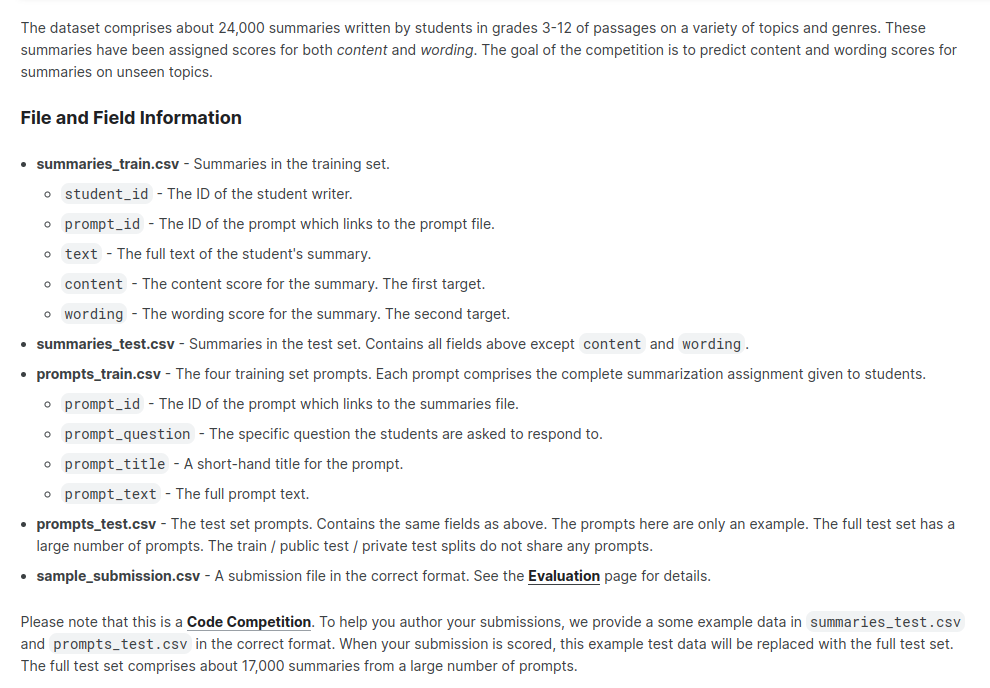

# Params

In [2]:
data_path = Path(r"/database/kaggle/Commontlit/data")
os.listdir(data_path)

['summaries_train.csv',
 'prompts_train.csv',
 'CLEAR_corpus_final.xlsx',
 'summaries_test.csv',
 'prompts_test.csv',
 'sample_submission.csv']

In [3]:
df = pd.read_csv(data_path/'summaries_train.csv')
df.shape

(7165, 5)

In [1]:
import transformers
transformers.__version__

'4.30.2'

In [4]:
df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.2057,0.3805
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.5483,0.5068
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.1289,4.2312
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.2106,-0.4714
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.2729,3.2198


In [78]:
import plotly.express as px

In [80]:
fig = px.histogram(df, x="content",facet_col="prompt_id")
fig.show()

In [77]:
df.groupby('prompt_id')[['content','wording']].value_counts()

prompt_id  content  wording
39c16e     0.2057   0.3805     150
           -1.5472  -1.4612     89
           -0.0938  0.5038      72
           -0.9813  -1.5489     71
           -1.2642  -1.5051     70
                              ... 
ebad26     0.9874   -0.9646      1
           0.9711   1.5536       1
           0.9708   -0.8851      1
           -0.9051  -1.2931      1
           3.5032   3.6381       1
Name: count, Length: 2072, dtype: int64

In [9]:
df.student_id.value_counts().value_counts()

count
1    7165
Name: count, dtype: int64

In [5]:
df_promp = pd.read_csv(data_path/'prompts_train.csv')
df_promp.shape

(4, 4)

In [7]:
df_promp

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [51]:
import torch
import random
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from tqdm.auto import tqdm

from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, AutoModel, AutoConfig

%env TOKENIZERS_PARALLELISM = true

def clean_text(text):
    # text = text.replace(u'\x9d', u' ')
    # text = resolve_encodings_and_normalize(text)
    text = text.strip()
    return text

## =============================================================================== ##
class CommonLitDataset(Dataset):
    def __init__(self,
                 df,
                 tokenizer,
                 max_length=512,
                 clean_input = True,
                 mask_pct = 0.15,
                 target = ['content', 'wording'],
                ):
        
        self.mask_pct = mask_pct
        self.clean_input = clean_input
        self.tokenizer = tokenizer

        self.max_length = max_length
        self.special_tokens = [tokenizer.cls_token_id,
                               tokenizer.sep_token_id,
                               tokenizer.pad_token_id,
                               tokenizer.mask_token_id
                              ]
        
        self.target = target
        df = self.prepare_df(df)
        
        self.items = []
        self.texts = []
        self.text_id = []
        self.targets = []
        self.spans_offset = []
        self.features = []

        if len(self.tokenizer.encode("\n\n"))==2:
            df["text"] = df['text'].transform(lambda x:x.str.replace("\n\n"," | "))

        for text_id,g in df.sort_values(["text_len"]).groupby('text_id',sort=False):
            self.texts.append(g['text'].values[0])
            self.text_id.append(text_id)
            self.targets.append(g[self.target].values.tolist()[0])

        for idx in tqdm(range(len(self.texts))):
            self.items.append(self.make_one_item(idx))
    
        self.df = df


    def prepare_df(self,df):
        df['text_id'] = df['student_id'].astype(str) + ' - ' + df['prompt_id'].astype(str)
        if self.clean_input:
            df["text"] = df['text'].astype(str).fillna('').apply(clean_text)
        if "content" not in df.columns:
            df[self.target] = 0
        df['text_len'] = df['text'].astype(str).fillna('').apply(len)
        return df
    
    def add_masking(self, data):
        mask_id = self.tokenizer.mask_token_id
        input_len = len(data['input_ids'])
        random_value = random.random() * self.mask_pct
        indices = random.sample(range(input_len), int(input_len * random_value))
        for idx in indices:
            if data['input_ids'][idx] not in self.special_tokens:
                data['input_ids'][idx] = mask_id

    def make_one_item(self,idx):

        encoding = self.tokenizer(
                                    self.texts[idx],
                                    truncation=True if self.max_length else False,
                                    max_length=self.max_length,
#                                     add_special_tokens = self.add_special_tokens,
                                    return_offsets_mapping=False if not len(self.spans_offset) else True,
                                )
        
        outputs = dict(**encoding)
        outputs['target'] = self.targets[idx]#*len(outputs['input_ids'])
        
        if self.mask_pct>0:
            self.add_masking(outputs)
        return outputs
    
    def __len__(self) -> int:
        return len(self.texts)
    
    def __getitem__(self,idx):
        return self.items[idx]

env: TOKENIZERS_PARALLELISM=true


In [52]:
class CustomCollator():
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.num_target = 2

    def __call__(self, batch):
        output = dict()

        output["input_ids"] = [sample["input_ids"] for sample in batch]
        output["attention_mask"] = [sample["attention_mask"] for sample in batch]
        output["target"] = [sample["target"] for sample in batch]

        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding
        if self.tokenizer.padding_side == "right":
            
#             output["target"] = [s + (batch_max - len(s)) * [[-1.]*self.num_target] for s in output["target"]]
            output["input_ids"] = [s + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["input_ids"]]
            output["attention_mask"] = [s + (batch_max - len(s)) * [0] for s in output["attention_mask"]]

        else:
#             output["target"] = [(batch_max - len(s)) * [[-1.]*self.num_target] + s for s in output["target"]]
            output["input_ids"] = [(batch_max - len(s)) * [self.tokenizer.pad_token_id] + s for s in output["input_ids"]]
            output["attention_mask"] = [(batch_max - len(s)) * [0] + s for s in output["attention_mask"]]

        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        output["attention_mask"] = torch.tensor(output["attention_mask"], dtype=torch.long)
        output["target"] = torch.tensor(output["target"], dtype=torch.float)
        return output

In [14]:
max_length = 512
model_name = 'microsoft/deberta-v3-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/jovyan/.local/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [53]:
ds = CommonLitDataset(df,tokenizer)

  0%|          | 0/7165 [00:00<?, ?it/s]

In [54]:
ds[0]

{'input_ids': [1,
  6421,
  678,
  278,
  1966,
  321,
  270,
  264,
  455,
  289,
  335,
  359,
  4062,
  128000,
  262,
  925,
  270,
  128000,
  288,
  266,
  326,
  260,
  263,
  1174,
  283,
  400,
  442,
  283,
  39968,
  10394,
  346,
  128000,
  2],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'target': [-1.54716321678788, -1.46124482282529]}

In [55]:
from torch.utils.data import Dataset, DataLoader

In [71]:
col = CustomCollator(tokenizer)
dl = DataLoader(ds, batch_size = 2,
                          num_workers=2, shuffle=False, drop_last=False, collate_fn=col)

In [72]:
for b in dl:
    break

In [73]:
b['target'].shape,b['input_ids'].shape

(torch.Size([2, 2]), torch.Size([2, 33]))

In [74]:
b['target']

tensor([[-1.5472, -1.4612],
        [-1.5472, -1.4612]])

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, all_hidden_states):
        all_layer_embedding = all_hidden_states[self.layer_start:, :, :, :]
        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()
        return weighted_average

class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings


class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim=1)
        return max_embeddings

class MinPooling(nn.Module):
    def __init__(self):
        super(MinPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = 1e4
        min_embeddings, _ = torch.min(embeddings, dim=1)
        return min_embeddings


class AttBlock(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear",
                 temperature=1.0):
        super().__init__()

        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

    def forward(self, x):
        # x: (n_samples, num_classes, num_tokens)
        norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
        # norm_att = torch.softmax(self.att(x), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=-1)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim
        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features,attention_mask):
        weights_mask = attention_mask.unsqueeze(-1)
        att = torch.tanh(self.W(features))
        score = self.V(att)
        score[attention_mask==0]=-1e4
        attention_weights = torch.softmax(score, dim=1)
        context_vector = torch.sum(attention_weights*weights_mask*features, dim=1)
        return context_vector


class GeMText(nn.Module):
    def __init__(self, dim=1, p=3, eps=1e-6):
        super(GeMText, self).__init__()
        self.dim = dim
        self.p = Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x, attention_mask):
        attention_mask_expanded = attention_mask.unsqueeze(-1).expand(x.shape)
        x = ((x.clamp(min=self.eps) * attention_mask_expanded).pow(self.p)).sum(self.dim)
        ret = (x/(attention_mask_expanded.sum(self.dim))).clip(min=self.eps)
        ret = ret.pow(1/self.p)
        return ret

class NLPPooling(nn.Module):
    def __init__(self,**kwargs):
        super().__init__()
        self.__dict__.update(kwargs)
        if self.pooling_name =="SED":
            self.pooler = AttBlock(self.in_features, self.out_features, activation='linear')
        elif self.pooling_name =="AttentionHead":
            self.pooler = AttentionHead(self.in_features, self.out_features)
        elif self.pooling_name not in ("CLS",''):
            self.pooler = eval(self.pooling_name)(**self.params)

        print(f'Pooling: {self.pooling_name}')

    def forward(self, last_hidden_state, attention_mask):

        if self.pooling_name in ['MeanPooling','MaxPooling','MinPooling']:
            # Pooling between cls and sep / cls and sep embedding are not included
            # last_hidden_state = self.pooler(last_hidden_state[:,1:-1,:],attention_mask[:,1:-1])
            last_hidden_state = self.pooler(last_hidden_state,attention_mask)
        elif self.pooling_name=="CLS":
            # Use only cls embedding
            last_hidden_state = last_hidden_state[:,0,:]
        elif self.pooling_name=="GeMText":
            # Use Gem Pooling on all tokens
            last_hidden_state = self.pooler(last_hidden_state,attention_mask)
        elif self.pooling_name=='SED':
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
            last_hidden_state = last_hidden_state*input_mask_expanded
            last_hidden_state = last_hidden_state.permute(0,2,1) # BS x Emb x token_size
            last_hidden_state,_,_ = self.pooler(last_hidden_state) # BS x Emb
        
        elif self.pooling_name=="AttentionHead":
            last_hidden_state = self.pooler(last_hidden_state,attention_mask)
        else:
            # No pooling
            last_hidden_state = last_hidden_state
            # print(f"{self.pooling_name} not implemented")
        return last_hidden_state 

In [81]:
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModel
import torch.utils.checkpoint
import torch.nn.functional as F
# from model_zoo.pooling import NLPPooling,WeightedLayerPooling
# from model_zoo.model_utils import reinit_last_layers,replace_with_fused_layernorm
# import gc

class CommonLitModel(nn.Module):
    def __init__(self,
                 model_name,
                 num_labels,
                 config_path=None,
                 use_gradient_checkpointing = False,
                 pooling_params={},
                 ):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name, output_hidden_states=True) if not config_path else torch.load(config_path)
        # if not self.use_dropout:
        self.config.update(
                            {
                                "hidden_dropout_prob": 0.0,
                                "attention_probs_dropout_prob": 0.0,
                            }
                                )
        
        self.backbone = AutoModel.from_pretrained(model_name,config=self.config) if not config_path else AutoModel.from_config(self.config)

        self.pooling_params = pooling_params
        self.pooling_params.update({"in_features":self.config.hidden_size,
                                    "out_features":self.config.hidden_size
                                    })
        self.pool_ly = NLPPooling(**self.pooling_params)

        if use_gradient_checkpointing:
            self.backbone.gradient_checkpointing_enable()

        self.fc = nn.Linear(self.config.hidden_size, num_labels)

    def forward(self,b):
                
        x = self.backbone(input_ids=b["input_ids"],attention_mask=b["attention_mask"]).last_hidden_state
        x = self.pool_ly(x,b['attention_mask'])
        x = self.fc(x) # BS x num_classes 
        return x

In [83]:
net = CommonLitModel(model_name,
                     num_labels=2,
                     config_path=None,
                     use_gradient_checkpointing = False,
                     pooling_params={"pooling_name":"CLS"},
                        )

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Pooling: CLS


In [84]:
x = net(b)

In [87]:
x

tensor([[-0.2019, -0.0293],
        [-0.1937, -0.0246]], grad_fn=<AddmmBackward0>)

In [155]:
import torch
from torch import nn

class RMSELoss(nn.Module):
    def __init__(self, reduction='none', eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.reduction = reduction
        self.eps = eps

    def forward(self, y_pred, y_true):
        loss = self.mse(y_pred.float(), y_true.float()) 
        
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum(dim=0)
        elif self.reduction == 'mean':
            loss = loss.mean(dim=0)
        
        return torch.sqrt(loss+ self.eps)

class FeedbackLoss(nn.Module):
    def __init__(self, loss_name='RMSELoss',
                 loss_param = {"reduction":"mean"},
                 reduction="mean",weights=None,
                 ):
        super().__init__()
        self.loss_func = eval(loss_name)(**loss_param)
        self.eps = 1e-9
        self.reduction = reduction
        self.weights = torch.tensor(weights) if weights else None

    def forward(self, y_pred, y_true):
        loss = self.loss_func(y_pred.float(), y_true.float())
        if self.weights is not None:
            loss = loss * self.weights.to(y_pred.device)
            if self.reduction == 'sum':
                loss = loss.sum()
            else:
                print(loss)
                loss = loss.sum() / self.weights.sum()
        else:
            if self.reduction == 'sum':
                loss = loss.sum()
            else:
                loss = loss.mean()
        return loss

import numpy as np

def mcrmse(targets, predictions):
    error = targets - predictions
    squared_error = np.square(error)
    colwise_mse = np.mean(squared_error, axis=0)
    root_colwise_mse = np.sqrt(colwise_mse)
    return np.mean(root_colwise_mse, axis=0)


def comp_metric(outputs, targets):
    colwise_rmse = torch.sqrt(torch.mean(torch.square(targets - outputs), dim=0))
    metric = torch.mean(colwise_rmse, dim=0)
    return metric, colwise_rmse

In [156]:
criterion = FeedbackLoss(weights=[0.4,0.6])

In [157]:
l = criterion(x,b['target'])

tensor([0.5397, 0.8606], grad_fn=<MulBackward0>)


In [158]:
l

tensor(1.4003, grad_fn=<DivBackward0>)

In [104]:
b['target']

tensor([[-1.5472, -1.4612],
        [-1.5472, -1.4612]])

In [160]:
x

tensor([[-0.2019, -0.0293],
        [-0.1937, -0.0246]], grad_fn=<AddmmBackward0>)

In [162]:
(-1.5472+0.2019)**2

1.8098320899999998

In [163]:
(-1.5472+0.1937)**2

1.83196225

In [164]:
(1.8098320899999998+1.83196225)/2

1.8208971699999998

In [165]:
np.sqrt(1.8208971699999998)

1.349406228679859

In [166]:
1.349406228679859*0.4

0.5397624914719436